c:\Users\thant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\thant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\thant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\thant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\thant\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the 

Training Metrics:
Accuracy: 0.9158607350096711
ROC AUC Score: 0.9782669694600226

Classification Report (Training):
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       517
           1       0.95      0.88      0.91       517

    accuracy                           0.92      1034
   macro avg       0.92      0.92      0.92      1034
weighted avg       0.92      0.92      0.92      1034


Testing Metrics:
Accuracy: 0.865625
ROC AUC Score: 0.8883552506194016

Classification Report (Testing):
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       795
           1       0.63      0.53      0.57       165

    accuracy                           0.87       960
   macro avg       0.77      0.73      0.75       960
weighted avg       0.86      0.87      0.86       960



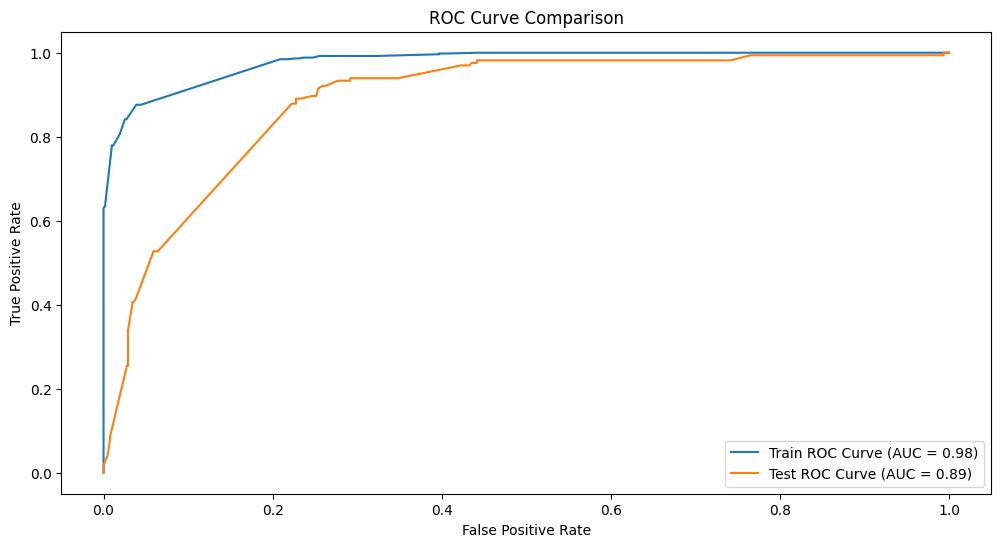

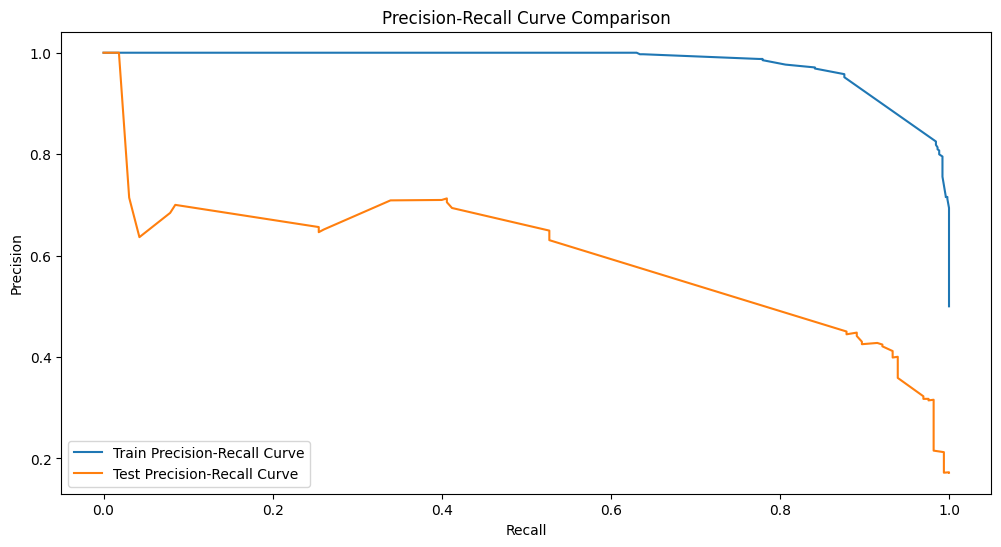

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('training_data_fall2024.csv')

# Convert target variable to numeric
df['increase_stock'] = df['increase_stock'].apply(lambda x: 1 if x == 'high_bike_demand' else 0)

# Feature engineering function
def feature_engineering(df):
    df['is_rush_hour'] = df['hour_of_day'].isin([7, 8, 9, 16, 17, 18]).astype(int)
    df['is_night'] = df['hour_of_day'].isin(list(range(22, 24)) + list(range(0, 5))).astype(int)
    df['is_weekend'] = df['day_of_week'].isin([0, 6]).astype(int)
    df['temp_humidity_interaction'] = df['temp'] * df['humidity']
    df['feels_like'] = df['temp'] - 0.2 * (1 - df['humidity'] / 100)
    df['temp_category'] = pd.cut(df['temp'], bins=[-np.inf, 0, 10, 20, 30, np.inf], labels=[0, 1, 2, 3, 4])
    df['is_precipitation'] = ((df['precip'] > 0) | (df['snow'] > 0)).astype(int)
    df['wind_category'] = pd.cut(df['windspeed'], bins=[-np.inf, 5, 10, 15, 20, np.inf], labels=[0, 1, 2, 3, 4])
    df['cloud_category'] = pd.cut(df['cloudcover'], bins=[-np.inf, 20, 40, 60, 80, np.inf], labels=[0, 1, 2, 3, 4])
    return df

# Apply feature engineering
df = feature_engineering(df)

# Define feature lists
numerical_features = ['temp', 'dew', 'humidity', 'precip', 'snow', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'temp_humidity_interaction', 'feels_like']
binary_features = ['holiday', 'weekday', 'summertime', 'is_rush_hour', 'is_night', 'is_weekend', 'is_precipitation']
categorical_features = ['hour_of_day', 'day_of_week', 'month', 'temp_category', 'cloud_category']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df[numerical_features + binary_features + categorical_features],
    df['increase_stock'],
    test_size=0.6,
    random_state=42
)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical_features),
    ],
    remainder='passthrough'
)

# Preprocess data
X_train_preprocessed = preprocessor.fit_transform(X_train_resampled)
X_test_preprocessed = preprocessor.transform(X_test)

# Feature selection with RFE
rfe = RFE(estimator=LogisticRegression(class_weight='balanced'), n_features_to_select=14)
X_train_rfe = rfe.fit_transform(X_train_preprocessed, y_train_resampled)
X_test_rfe = X_test_preprocessed[:, rfe.support_]

# Grid search for hyperparameter tuning
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(random_state=42, class_weight='balanced'), param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train_rfe, y_train_resampled)

# Best model
best_model = grid_search.best_estimator_

# Predictions for training and test sets
y_train_pred = best_model.predict(X_train_rfe)
y_train_pred_proba = best_model.predict_proba(X_train_rfe)[:, 1]
y_test_pred = best_model.predict(X_test_rfe)
y_test_pred_proba = best_model.predict_proba(X_test_rfe)[:, 1]

# Evaluation Metrics
print("Training Metrics:")
print("Accuracy:", accuracy_score(y_train_resampled, y_train_pred))
print("ROC AUC Score:", roc_auc_score(y_train_resampled, y_train_pred_proba))
print("\nClassification Report (Training):")
print(classification_report(y_train_resampled, y_train_pred))

print("\nTesting Metrics:")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_test_pred_proba))
print("\nClassification Report (Testing):")
print(classification_report(y_test, y_test_pred))

# ROC Curve comparison
train_fpr, train_tpr, _ = roc_curve(y_train_resampled, y_train_pred_proba)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(12, 6))
plt.plot(train_fpr, train_tpr, label="Train ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_train_resampled, y_train_pred_proba)))
plt.plot(test_fpr, test_tpr, label="Test ROC Curve (AUC = {:.2f})".format(roc_auc_score(y_test, y_test_pred_proba)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

# Precision-Recall Curve comparison
train_precision, train_recall, _ = precision_recall_curve(y_train_resampled, y_train_pred_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_pred_proba)

plt.figure(figsize=(12, 6))
plt.plot(train_recall, train_precision, label="Train Precision-Recall Curve")
plt.plot(test_recall, test_precision, label="Test Precision-Recall Curve")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend()
plt.show()
